In [72]:
import json
import pandas as pd
import os
import re

# 대상 폴더 경로 설정
folder_path = r"\Users\kyn03\OneDrive\바탕 화면\project_file\interactive_wordcloud"

# 정규표현식을 사용하여 .json 파일 필터링
file_paths = [
    os.path.join(folder_path, filename)
    for filename in os.listdir(folder_path)
    if re.match(r".*\.json$", filename)  # 여기서 .json 파일만 필터링
]

data = {}
for path in file_paths:
    with open(path, "r", encoding="utf-8") as file:  # UTF-8 인코딩 설정
        # 파일명에서 브랜드, 속성, 감성 추출
        filename = os.path.basename(path)  # 파일명만 가져옴
        match = re.match(r"^([a-zA-Z가-힣]+)_([a-zA-Z가-힣_]+)_(positive|negative).*\.json$", filename)

        if match:
            brand = match.group(1)       # 첫 번째 그룹: 브랜드명
            category = match.group(2)    # 두 번째 그룹: 속성명 (다중 언더스코어 포함 가능)
            sentiment = match.group(3)   # 세 번째 그룹: 긍정/부정
            
            # JSON 데이터 불러오기
            words = json.load(file)
            for word, count in words.items():
                data.setdefault((brand, category, sentiment), []).append((word, count))
        else:
            print(f"파일명 형식이 맞지 않음: {filename}")

# 데이터 예시 출력
for key, words in data.items():
    print(f"{key}: {words[:5]}")  # 각 브랜드-카테고리-감성의 상위 5개 단어 출력

('달바', '가격', 'negative'): [('정가에', 1), ('가격에', 1), ('가격이', 54), ('미스트로', 1), ('평소', 1)]
('달바', '가격', 'positive'): [('듀오', 1), ('가성비가', 10), ('기획', 1), ('더블', 6), ('할인있으니', 1)]
('달바', '사용감_착용감', 'negative'): [('지성', 16), ('향과', 5), ('피부에', 7), ('향이', 86), ('민감한', 5)]
('달바', '사용감_착용감', 'positive'): [('가벼운', 4), ('자극받은', 1), ('피부를', 10), ('생기를', 3), ('피부가', 45)]
('달바', '사이즈_무게_개수', 'negative'): [('용량도', 1), ('오일이', 1), ('요즘은', 1), ('크고', 1), ('실제사용하기에는', 1)]
('달바', '사이즈_무게_개수', 'positive'): [('한', 2), ('크기', 1), ('가족꺼까지', 1), ('양도', 9), ('용량도', 9)]
('달바', '제조_유통_서비스', 'negative'): [('제조일자가', 2), ('2022', 1), ('제조일자를', 1), ('제조일자', 2), ('1월이라', 1)]
('달바', '제조_유통_서비스', 'positive'): [('사용기한도', 1), ('유통기한도', 4), ('유통기한', 2), ('소비기한', 1), ('길고', 1)]
('달바', '편의성_활용성', 'negative'): [('한번에', 1), ('세수하고', 2), ('사르르르', 1), ('스킨케어', 1), ('여름에', 1)]
('달바', '편의성_활용성', 'positive'): [('아침', 8), ('휴대하기에도', 1), ('스킨', 38), ('편리하고', 10), ('어디를', 7)]
('달바', '품질_디자인_구성', 'negative'): [('모공을', 7), ('자극을', 5),

In [54]:
# 통합 데이터프레임 생성
df = pd.DataFrame(columns=["Brand", "Category", "Sentiment", "Word", "Frequency"])

# 데이터프레임에 데이터 추가
rows = []
for (brand, category, sentiment), words in data.items():
    for word, count in words:
        # 행을 추가할 때 딕셔너리를 이용해 리스트에 추가
        rows.append({
            "Brand": brand,
            "Category": category,
            "Sentiment": sentiment,
            "Word": word,
            "Frequency": count
        })

# pd.concat()을 사용해 DataFrame 생성
df = pd.concat([df, pd.DataFrame(rows)], ignore_index=True)
print(df.head())


  Brand Category Sentiment  Word Frequency
0    달바       가격  negative   정가에         1
1    달바       가격  negative   가격에         1
2    달바       가격  negative   가격이        54
3    달바       가격  negative  미스트로         1
4    달바       가격  negative    평소         1


In [71]:
from gensim.models import Word2Vec

# 데이터프레임을 문장 리스트 형식으로 변환
# Category와 Sentiment를 기준으로 단어를 그룹화하여 문장 형식으로 구성
sentences = df.groupby(['Category', 'Sentiment'])['Word'].apply(list).tolist()

# Step 7: Word2Vec 모델 학습
word2vec_model = Word2Vec(
    sentences=sentences,   # 그룹화된 단어 리스트의 리스트
    vector_size=100,       # 벡터 크기
    window=5,              # 컨텍스트 윈도우 크기
    min_count=1,           # 최소 단어 빈도수
    workers=4,             # 작업 스레드 수
    sg=1                   # CBOW (0) 또는 Skip-gram (1)
)

# Step 8: 모델 저장
word2vec_model.save("word2vec_model.model")
print("Word2Vec 모델이 'word2vec_model.model'로 저장되었습니다.")

# Step 9: 모델 테스트: 유사한 단어 찾기
print("Model vocabulary:", word2vec_model.wv.index_to_key)

# 모델에 실제 포함된 첫 번째 단어로 유사 단어 찾기
if len(word2vec_model.wv.index_to_key) > 0:
    example_word = word2vec_model.wv.index_to_key[0]
    similar_words = word2vec_model.wv.most_similar(example_word, topn=5)
    print(f"Words similar to '{example_word}':", similar_words)
else:
    print("No words in the vocabulary.")

ImportError: cannot import name 'triu' from 'scipy.linalg' (c:\Users\kyn03\anaconda3\Lib\site-packages\scipy\linalg\__init__.py)

C:\Users\kyn03\AppData\Local\Temp\ipykernel_30316\2923699275.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_words = df.groupby(['Brand', 'Category', 'Sentiment'], group_keys=False).apply(lambda x: x.nlargest(2, 'Frequency')).reset_index(drop=True)
c:\Users\kyn03\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


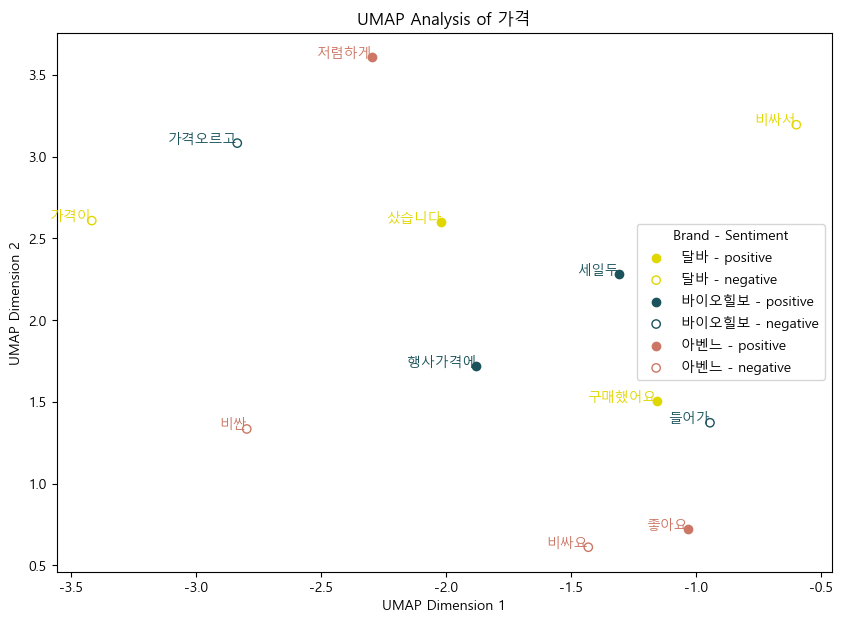

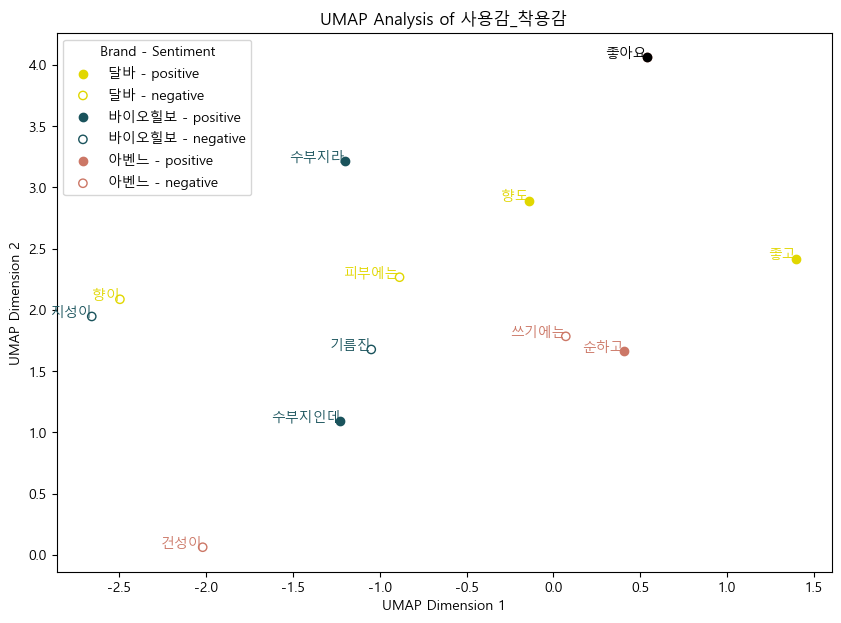

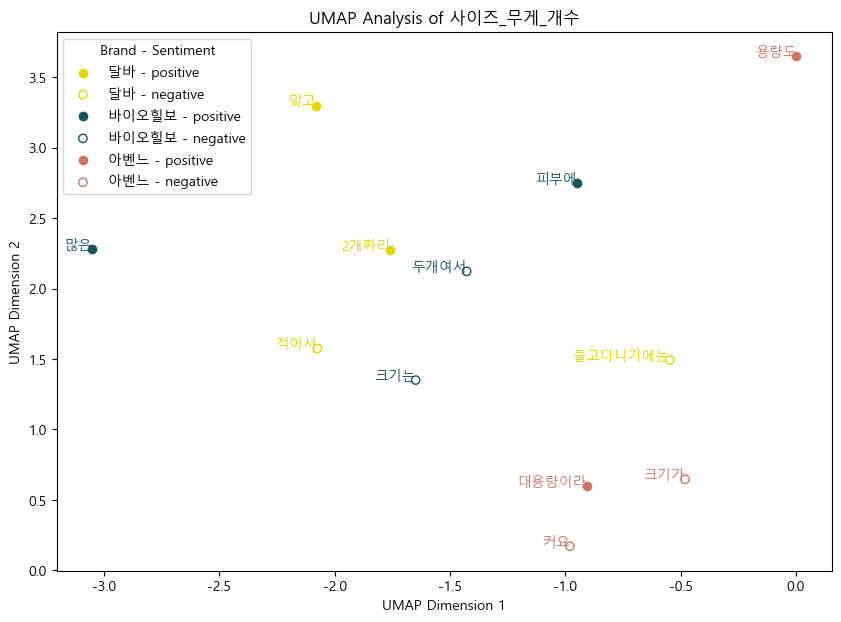

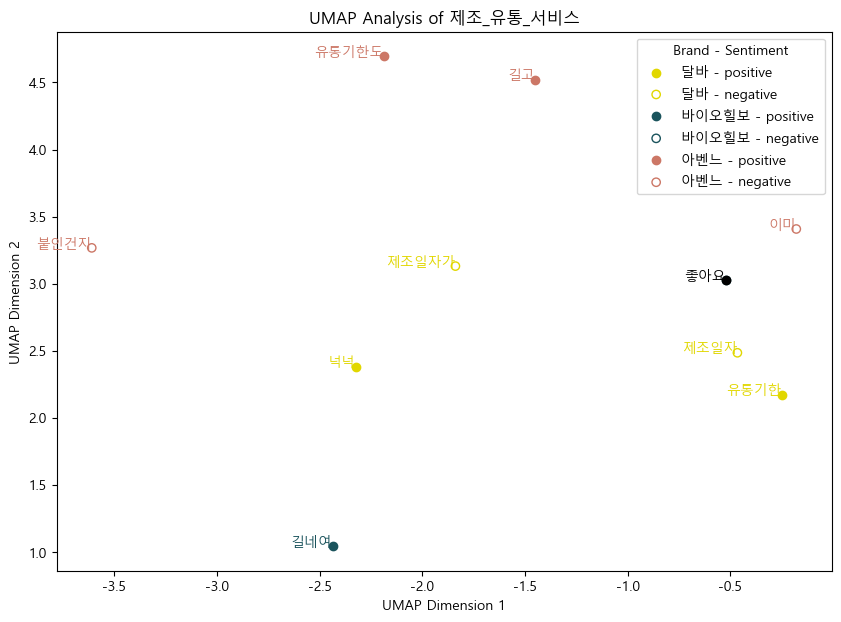

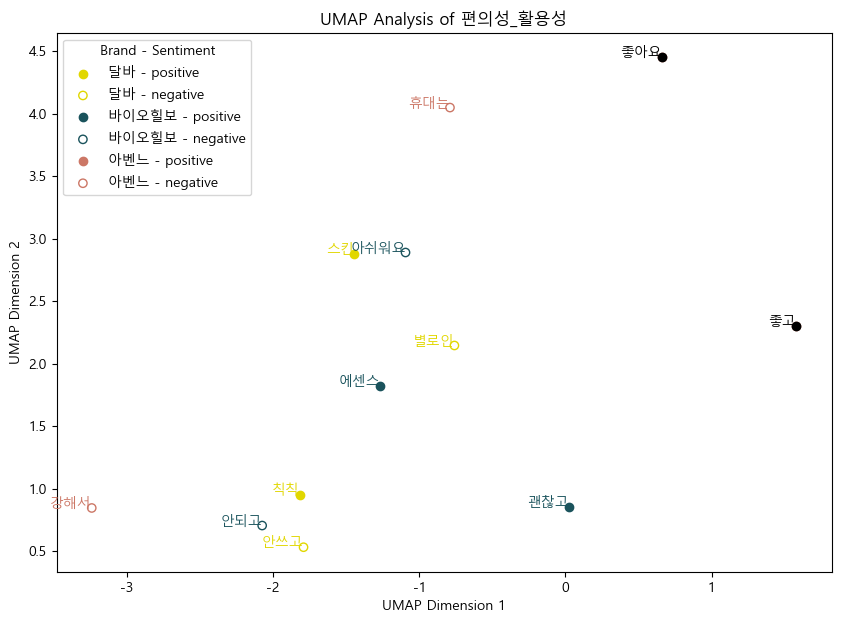

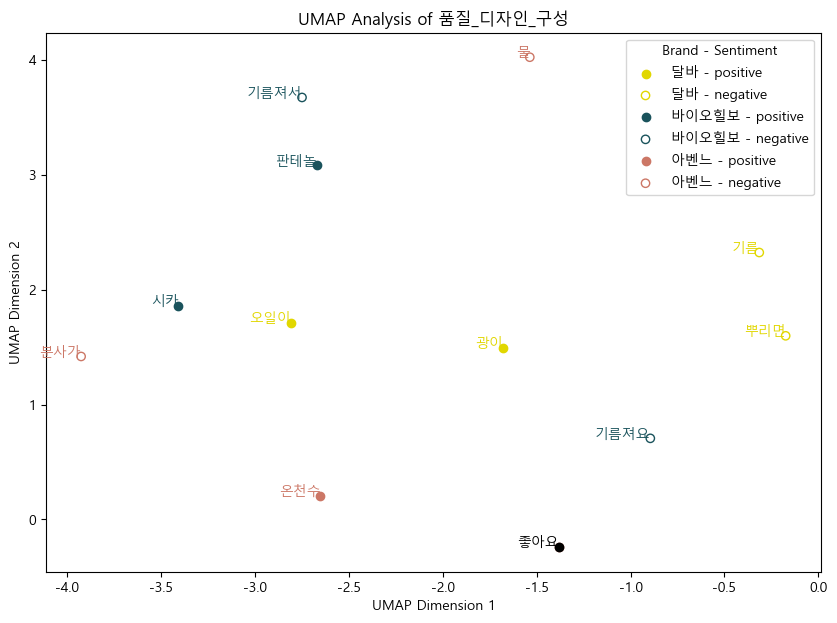

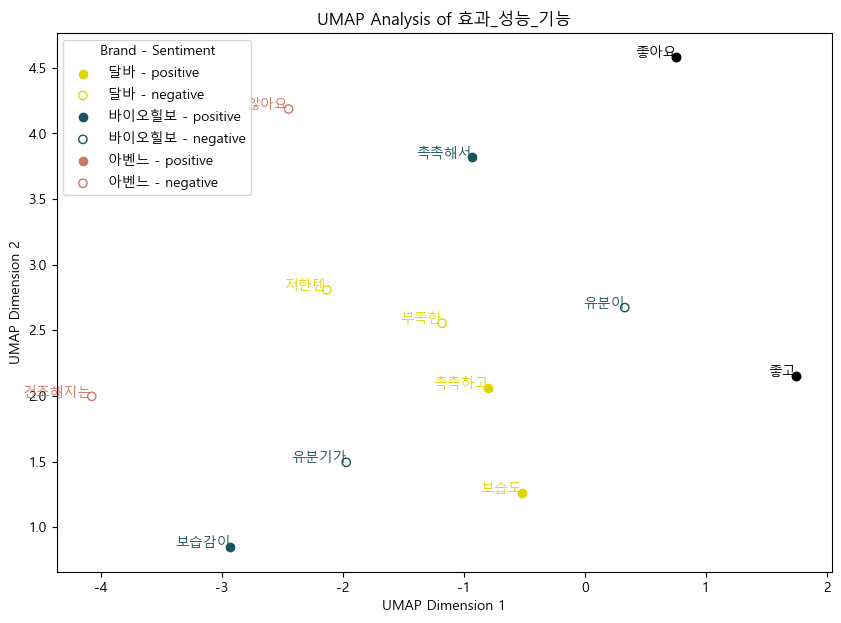

In [69]:
import pandas as pd
import umap
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

# 한글 폰트 설정
font_path = "C:/Windows/Fonts/malgun.ttf"  # 윈도우의 경우
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

# 마이너스 기호 깨짐 방지
rc('axes', unicode_minus=False)


# 각 브랜드에 대한 고유 색상 설정
brand_colors = {'달바': '#E1D700', '바이오힐보': '#1a535c', '아벤느': '#cc7766'}

# Frequency를 숫자형으로 변환
df['Frequency'] = pd.to_numeric(df['Frequency'], errors='coerce')

# 각 속성 내에서 중복 단어 제거하고 빈도가 가장 높은 항목만 남김
df = df.sort_values('Frequency', ascending=False).drop_duplicates(subset=['Word', 'Category'], keep='first')

# 속성별로 감정에 따라 상위 2개의 단어 선택
top_words = df.groupby(['Brand', 'Category', 'Sentiment'], group_keys=False).apply(lambda x: x.nlargest(2, 'Frequency')).reset_index(drop=True)

# 피벗 테이블 생성
features = pd.pivot_table(top_words, index=top_words.index, columns='Word', values='Frequency', fill_value=0)

# UMAP 모델 적용을 위한 데이터 준비
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
umap_model = umap.UMAP(n_neighbors=5, min_dist=0.3, random_state=42)
umap_transformed = umap_model.fit_transform(scaled_features)

# UMAP 결과를 top_words에 추가
top_words[['UMAP Dimension 1', 'UMAP Dimension 2']] = umap_transformed

# 중복된 단어 추적을 위한 집합 생성
unique_words = set()

# 속성별 시각화
for category in top_words['Category'].unique():
    category_data = top_words[top_words['Category'] == category]
    
    plt.figure(figsize=(10, 7))
    plt.title(f"UMAP Analysis of {category}")
    
    for brand, color in brand_colors.items():
        brand_data = category_data[category_data['Brand'] == brand]
        
        for sentiment in ['positive', 'negative']:
            sentiment_data = brand_data[brand_data['Sentiment'] == sentiment]
            marker_style = 'o' if sentiment == 'positive' else 'o'  # 채움 여부는 아래 facecolors로 구분
            
            plt.scatter(sentiment_data['UMAP Dimension 1'], sentiment_data['UMAP Dimension 2'],
                        label=f"{brand} - {sentiment}", color=color, marker=marker_style,
                        facecolors=color if sentiment == 'positive' else 'none', edgecolors=color)
            
            for _, row in sentiment_data.iterrows():
                word_label = row['Word']
                
                # 중복된 단어는 검정색 점으로 한 번만 표시
                if word_label not in unique_words:
                    plt.text(row['UMAP Dimension 1'], row['UMAP Dimension 2'], word_label, ha='right', color=color)
                    unique_words.add(word_label)
                else:
                    plt.scatter(row['UMAP Dimension 1'], row['UMAP Dimension 2'], color='black', marker='o')
                    plt.text(row['UMAP Dimension 1'], row['UMAP Dimension 2'], word_label, ha='right', color='black')

    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.legend(title="Brand - Sentiment")
    plt.show()


c:\Users\kyn03\anaconda3\Lib\site-packages\umap\umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
C:\Users\kyn03\AppData\Local\Temp\ipykernel_30316\4122014645.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  category_data['UMAP Dimension 1'] = umap_transformed[:, 0]
C:\Users\kyn03\AppData\Local\Temp\ipykernel_30316\4122014645.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  category_data['UMAP Dimension 2'] = umap_transformed[:, 1]
C:\Users\k

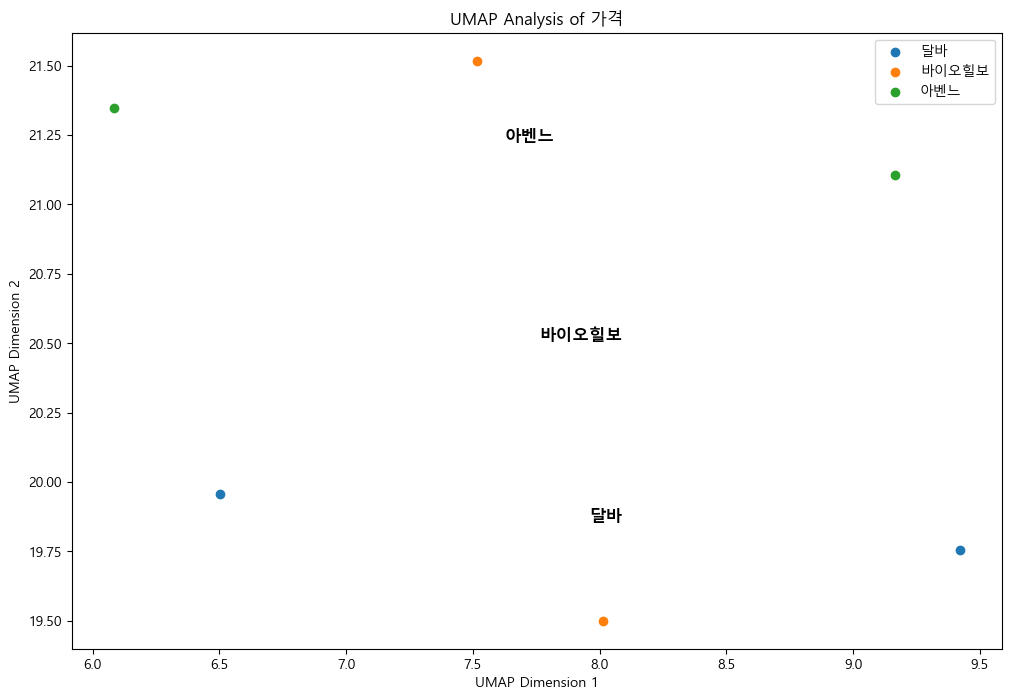

c:\Users\kyn03\anaconda3\Lib\site-packages\umap\umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
C:\Users\kyn03\AppData\Local\Temp\ipykernel_30316\4122014645.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  category_data['UMAP Dimension 1'] = umap_transformed[:, 0]
C:\Users\kyn03\AppData\Local\Temp\ipykernel_30316\4122014645.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  category_data['UMAP Dimension 2'] = umap_transformed[:, 1]
C:\Users\k

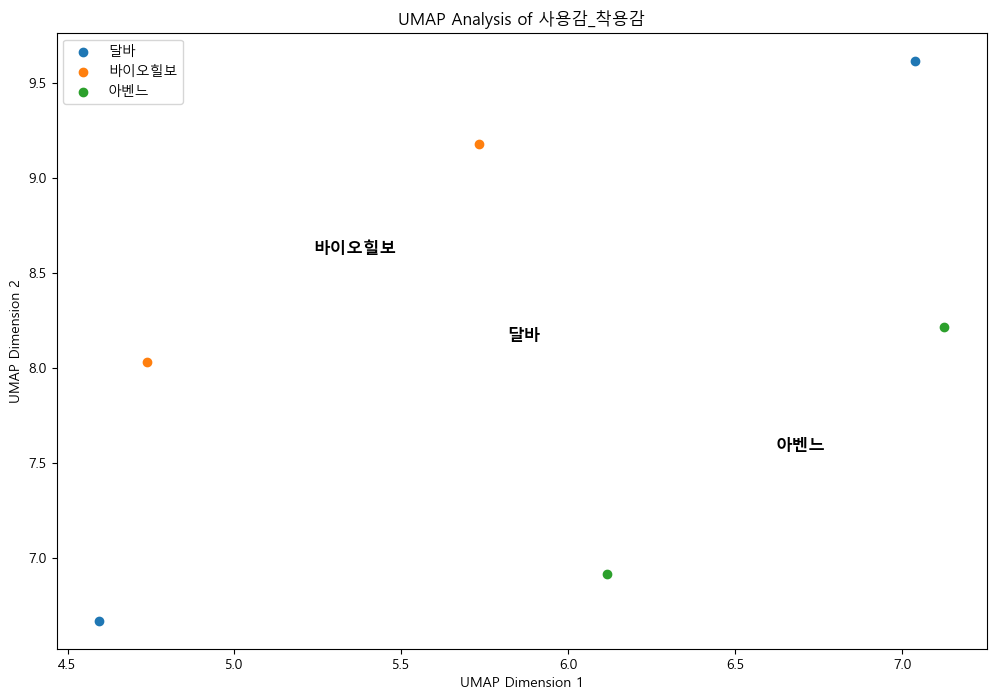

c:\Users\kyn03\anaconda3\Lib\site-packages\umap\umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
C:\Users\kyn03\AppData\Local\Temp\ipykernel_30316\4122014645.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  category_data['UMAP Dimension 1'] = umap_transformed[:, 0]
C:\Users\kyn03\AppData\Local\Temp\ipykernel_30316\4122014645.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  category_data['UMAP Dimension 2'] = umap_transformed[:, 1]
C:\Users\k

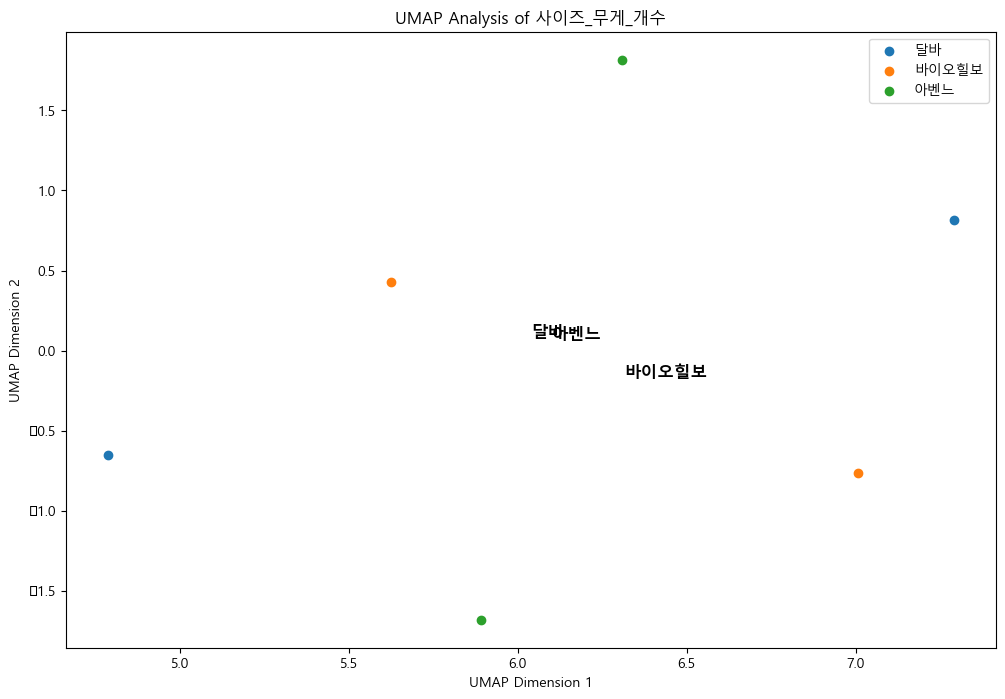

c:\Users\kyn03\anaconda3\Lib\site-packages\umap\umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
C:\Users\kyn03\AppData\Local\Temp\ipykernel_30316\4122014645.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  category_data['UMAP Dimension 1'] = umap_transformed[:, 0]
C:\Users\kyn03\AppData\Local\Temp\ipykernel_30316\4122014645.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  category_data['UMAP Dimension 2'] = umap_transformed[:, 1]
C:\Users\k

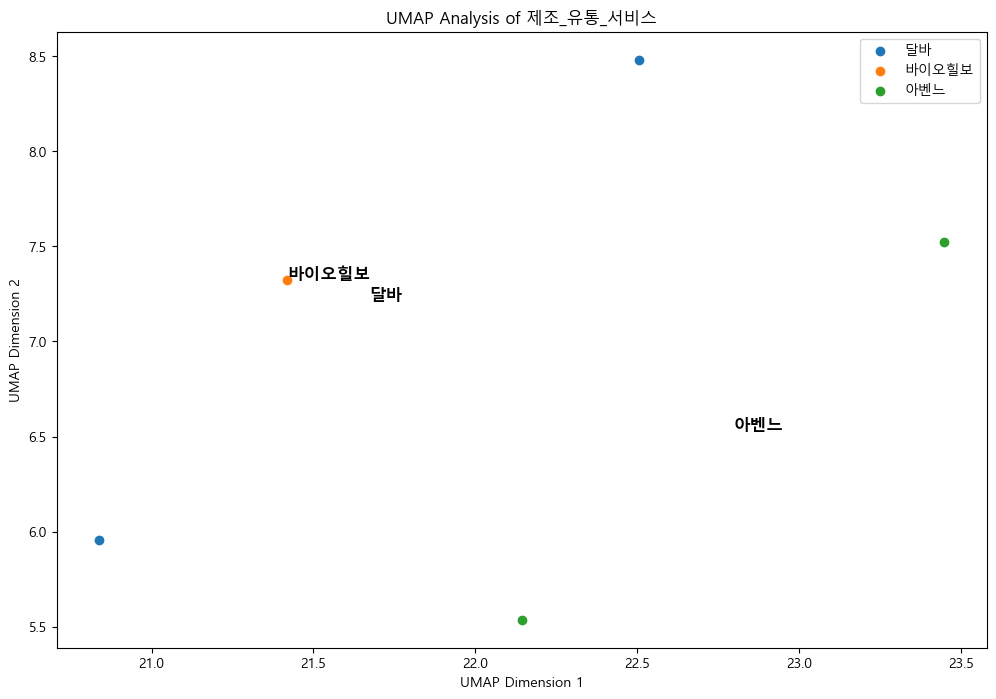

c:\Users\kyn03\anaconda3\Lib\site-packages\umap\umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
C:\Users\kyn03\AppData\Local\Temp\ipykernel_30316\4122014645.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  category_data['UMAP Dimension 1'] = umap_transformed[:, 0]
C:\Users\kyn03\AppData\Local\Temp\ipykernel_30316\4122014645.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  category_data['UMAP Dimension 2'] = umap_transformed[:, 1]
C:\Users\k

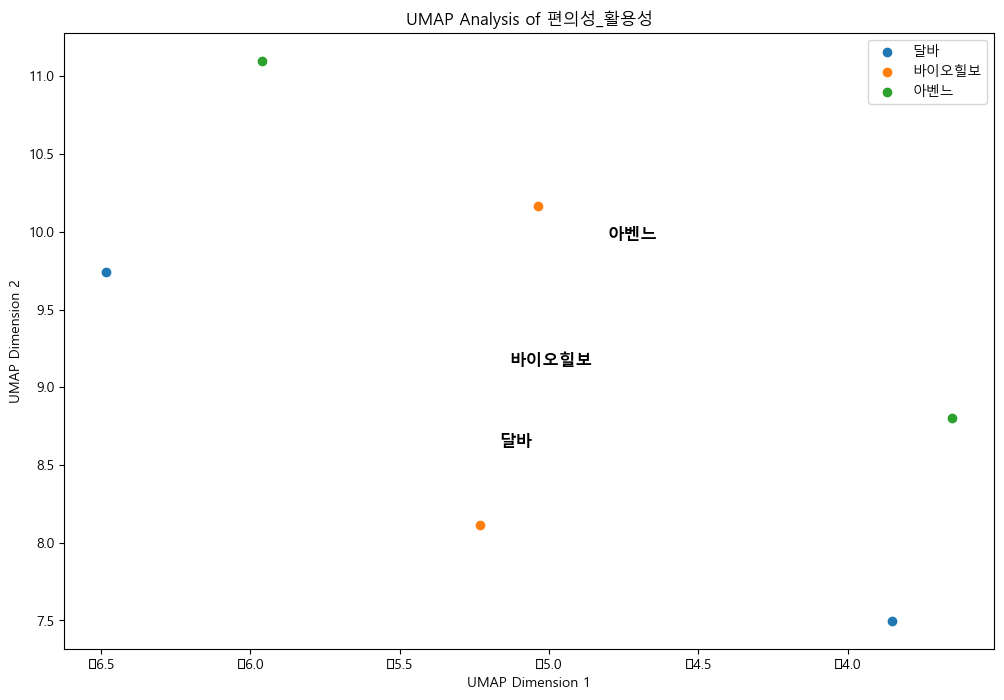

c:\Users\kyn03\anaconda3\Lib\site-packages\umap\umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
C:\Users\kyn03\AppData\Local\Temp\ipykernel_30316\4122014645.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  category_data['UMAP Dimension 1'] = umap_transformed[:, 0]
C:\Users\kyn03\AppData\Local\Temp\ipykernel_30316\4122014645.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  category_data['UMAP Dimension 2'] = umap_transformed[:, 1]
C:\Users\k

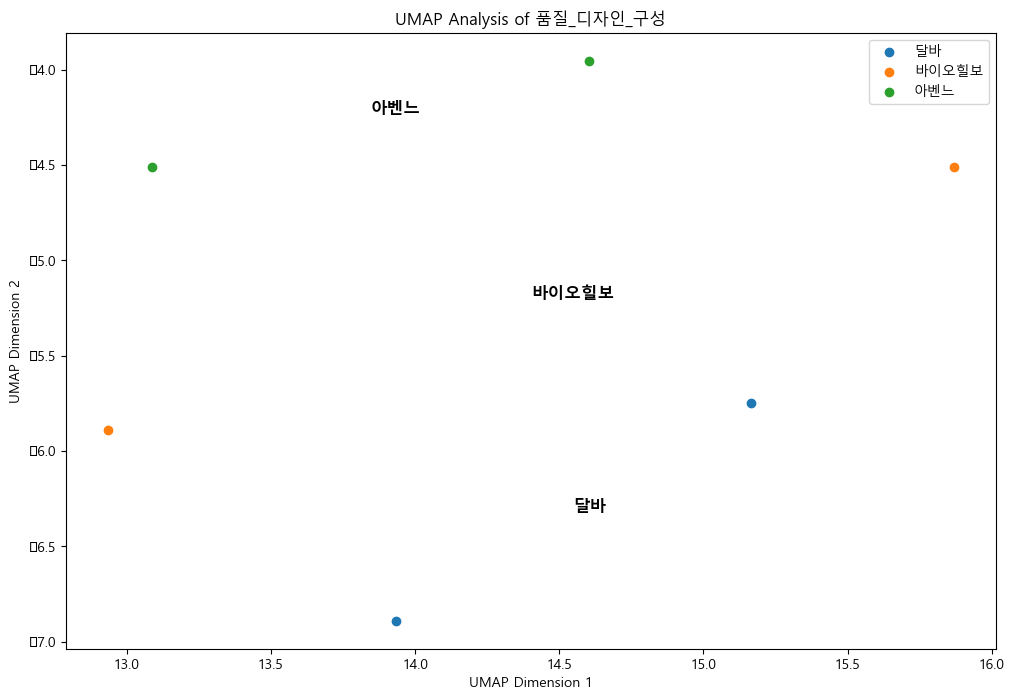

c:\Users\kyn03\anaconda3\Lib\site-packages\umap\umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
C:\Users\kyn03\AppData\Local\Temp\ipykernel_30316\4122014645.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  category_data['UMAP Dimension 1'] = umap_transformed[:, 0]
C:\Users\kyn03\AppData\Local\Temp\ipykernel_30316\4122014645.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  category_data['UMAP Dimension 2'] = umap_transformed[:, 1]
C:\Users\k

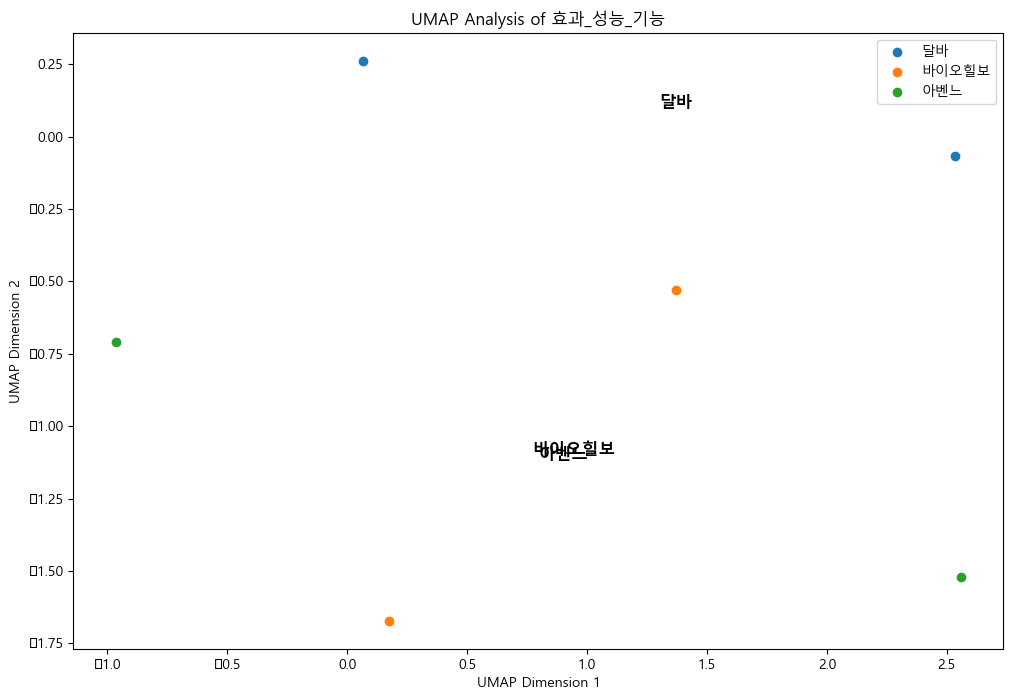

In [43]:
unique_categories = pivot_df['Category'].unique()

for category in unique_categories:
    plt.figure(figsize=(12, 8))
    category_data = pivot_df[pivot_df['Category'] == category]
    umap_transformed = umap_model.fit_transform(category_data.drop(columns=["Brand", "Category", "Sentiment"]))
    category_data['UMAP Dimension 1'] = umap_transformed[:, 0]
    category_data['UMAP Dimension 2'] = umap_transformed[:, 1]

    for brand_index, brand in enumerate(category_data['Brand'].unique()):
        brand_data = category_data[category_data["Brand"] == brand]
        plt.scatter(brand_data['UMAP Dimension 1'], brand_data['UMAP Dimension 2'], label=brand)

        # 브랜드별로 중심 표시
        centroid = brand_data[['UMAP Dimension 1', 'UMAP Dimension 2']].mean()
        plt.text(centroid[0], centroid[1], brand, fontsize=12, weight='bold')

    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.title(f"UMAP Analysis of {category}")
    plt.legend()
    plt.show()


In [16]:
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

# 한글 폰트 설정
font_path = "C:/Windows/Fonts/malgun.ttf"  # 윈도우의 경우
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

# 분석할 데이터 준비 (Brand, Category, Sentiment 제외)
mca_data = pivot_df.drop(columns=["Brand", "Category", "Sentiment"])

# 로그 변환 적용
mca_data_log = np.log1p(mca_data)  # np.log1p는 log(1 + x)를 계산하여 0일 때도 안전하게 변환

# 데이터 스케일링
scaler = StandardScaler()
mca_data_scaled_log = scaler.fit_transform(mca_data_log)


c:\Users\kyn03\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


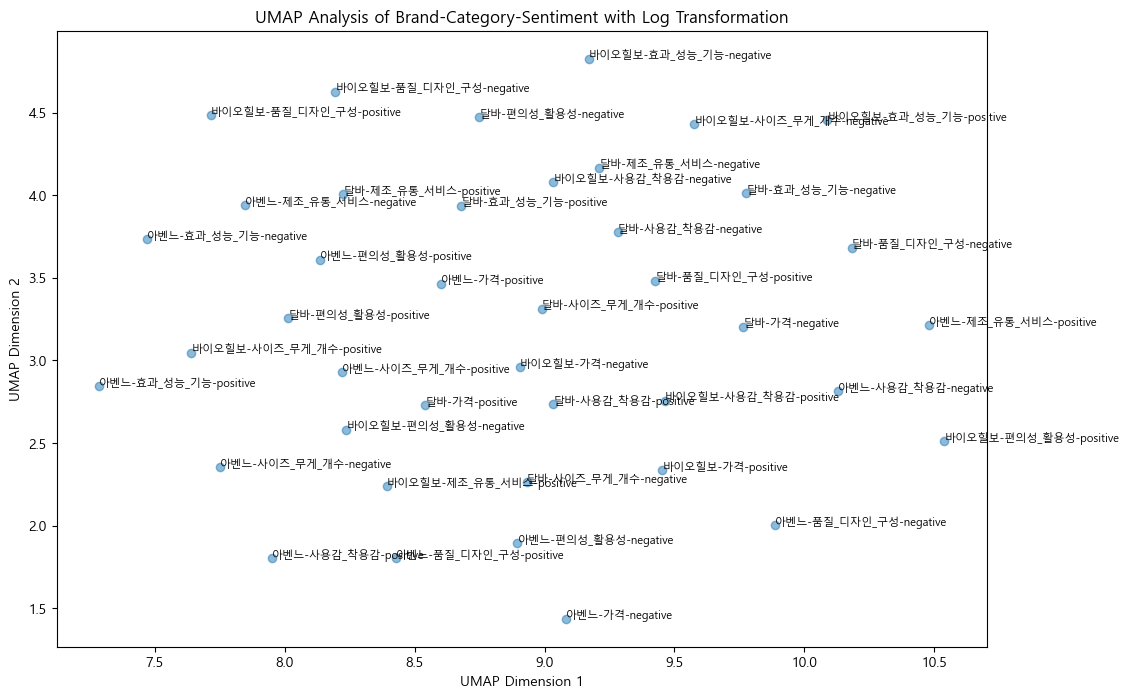

In [9]:
import umap.umap_ as umap

# UMAP 모델 설정 및 피팅
umap_model = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.1, random_state=42)
umap_transformed = umap_model.fit_transform(mca_data_scaled_log)

# 시각화
plt.figure(figsize=(12, 8))
plt.scatter(umap_transformed[:, 0], umap_transformed[:, 1], alpha=0.5)
for i, (brand, category, sentiment) in enumerate(zip(pivot_df["Brand"], pivot_df["Category"], pivot_df["Sentiment"])):
    plt.text(umap_transformed[i, 0], umap_transformed[i, 1], f"{brand}-{category}-{sentiment}", fontsize=8)
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.title("UMAP Analysis of Brand-Category-Sentiment with Log Transformation")
plt.show()


C:\Users\kyn03\AppData\Local\Temp\ipykernel_30316\190027523.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab10", len(brands))


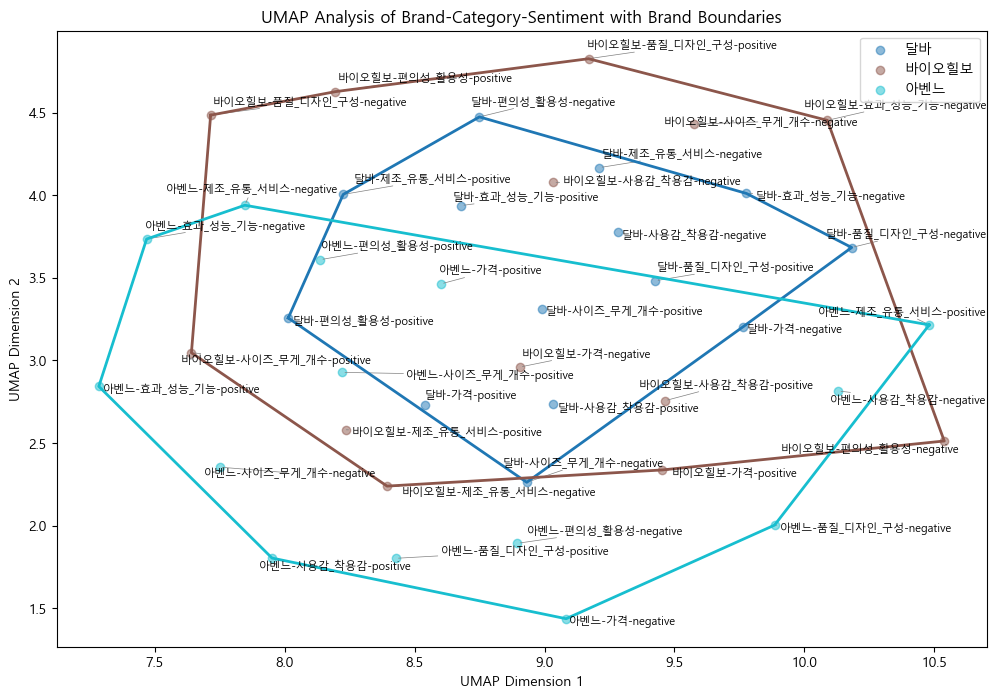

In [13]:
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
import numpy as np
from adjustText import adjust_text

# 브랜드별로 색상을 지정하기 위한 컬러 맵 설정
brands = pivot_df["Brand"].unique()
colors = plt.cm.get_cmap("tab10", len(brands))

plt.figure(figsize=(12, 8))

# UMAP 차원 축소 결과를 시각화
texts = []
for brand_index, brand in enumerate(brands):
    # 해당 브랜드의 데이터 선택
    brand_data = umap_transformed[pivot_df["Brand"] == brand]
    
    # 브랜드의 데이터 포인트 산점도
    plt.scatter(brand_data[:, 0], brand_data[:, 1], alpha=0.5, label=brand, color=colors(brand_index))
    
    # Convex Hull을 그리기 위한 경계선 계산
    if len(brand_data) >= 3:  # Convex Hull은 3개 이상의 포인트가 필요합니다
        hull = ConvexHull(brand_data)
        hull_points = np.append(hull.vertices, hull.vertices[0])  # 경계 닫기 위해 첫 점을 마지막에 추가
        plt.plot(brand_data[hull_points, 0], brand_data[hull_points, 1], color=colors(brand_index), lw=2)

    # 레이블 추가 및 adjust_text를 위해 texts 리스트에 저장
    for i in range(len(brand_data)):
        text = plt.text(brand_data[i, 0], brand_data[i, 1], f"{brand}-{pivot_df.iloc[i]['Category']}-{pivot_df.iloc[i]['Sentiment']}", fontsize=8)
        texts.append(text)

# adjust_text로 레이블 겹침 방지
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='gray', lw=0.5))

plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.title("UMAP Analysis of Brand-Category-Sentiment with Brand Boundaries")
plt.legend()
plt.show()


C:\Users\kyn03\AppData\Local\Temp\ipykernel_30316\2720246827.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab10", len(brands))


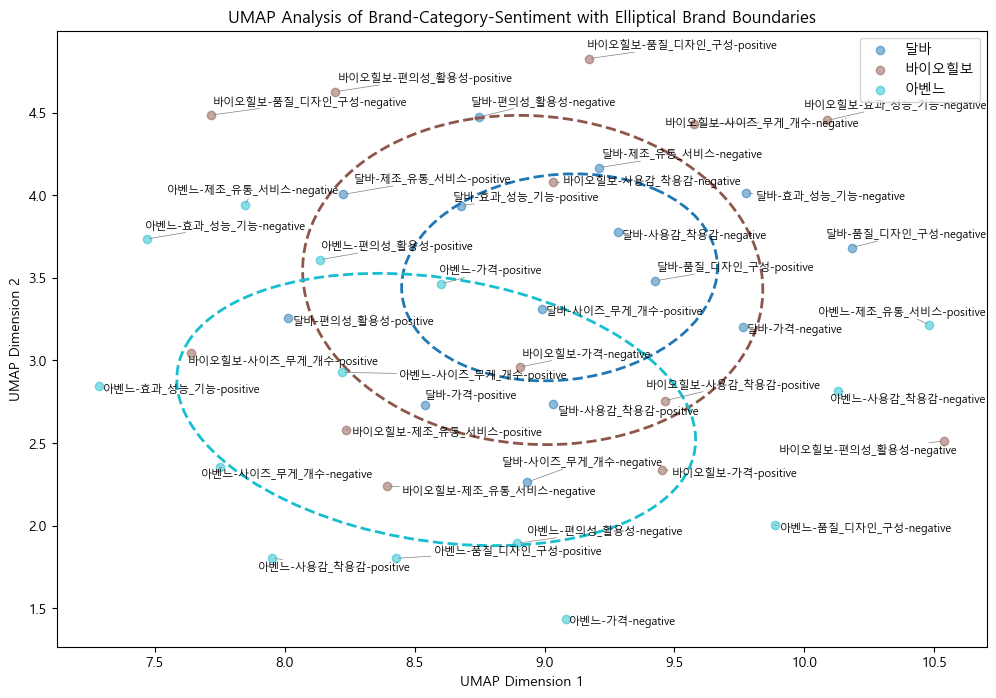

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse
from adjustText import adjust_text

# 브랜드별로 색상을 지정하기 위한 컬러 맵 설정
brands = pivot_df["Brand"].unique()
colors = plt.cm.get_cmap("tab10", len(brands))

plt.figure(figsize=(12, 8))

# UMAP 차원 축소 결과를 시각화
texts = []
for brand_index, brand in enumerate(brands):
    # 해당 브랜드의 데이터 선택
    brand_data = umap_transformed[pivot_df["Brand"] == brand]
    
    # 브랜드의 데이터 포인트 산점도
    plt.scatter(brand_data[:, 0], brand_data[:, 1], alpha=0.5, label=brand, color=colors(brand_index))
    
    # 타원형 경계 그리기
    cov = np.cov(brand_data, rowvar=False)  # 공분산 행렬 계산
    mean = np.mean(brand_data, axis=0)  # 평균 계산
    eigenvalues, eigenvectors = np.linalg.eigh(cov)  # 고유값 및 고유벡터 계산
    
    # 고유값에 따라 축의 길이를 설정
    axis_length = 2 * np.sqrt(eigenvalues)  # 95% 신뢰 구간을 위한 크기 조정
    
    # 타원 추가
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
    ellipse = Ellipse(xy=mean, width=axis_length[0], height=axis_length[1], angle=angle,
                      edgecolor=colors(brand_index), facecolor='none', lw=2, linestyle='--')
    plt.gca().add_patch(ellipse)

    # 레이블 추가 및 adjust_text를 위해 texts 리스트에 저장
    for i in range(len(brand_data)):
        text = plt.text(brand_data[i, 0], brand_data[i, 1], f"{brand}-{pivot_df.iloc[i]['Category']}-{pivot_df.iloc[i]['Sentiment']}", fontsize=8)
        texts.append(text)

# adjust_text로 레이블 겹침 방지
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='gray', lw=0.5))

plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.title("UMAP Analysis of Brand-Category-Sentiment with Elliptical Brand Boundaries")
plt.legend()
plt.show()


c:\Users\kyn03\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


KeyError: 'Word'

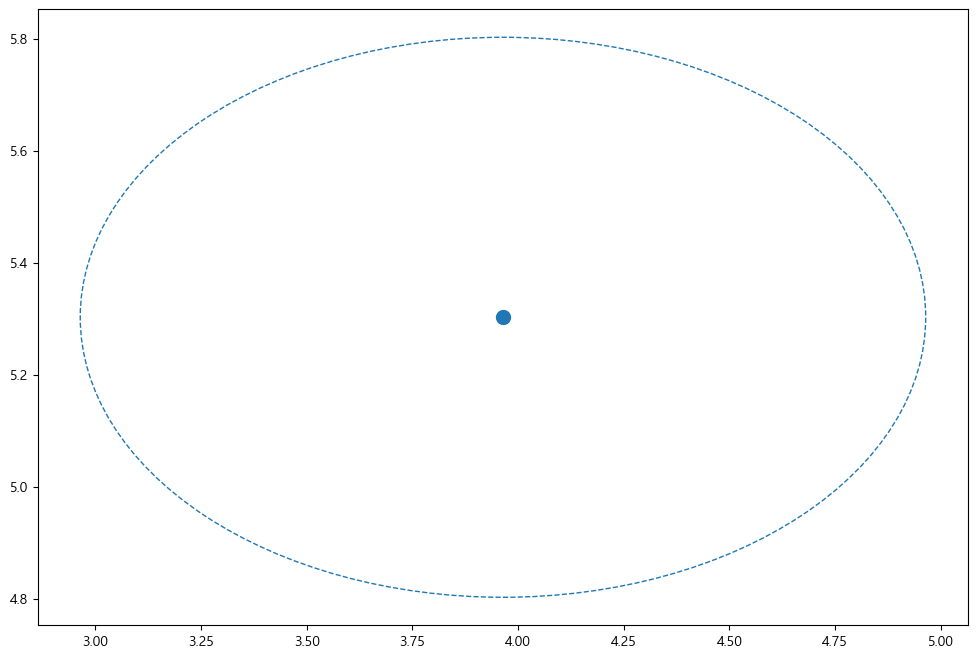

In [19]:
from sklearn.decomposition import PCA  # UMAP 대신 PCA 사용 가능
import umap
import matplotlib.pyplot as plt
import numpy as np
from adjustText import adjust_text
from matplotlib.patches import Ellipse

# UMAP 차원 축소 적용
umap_model = umap.UMAP(n_components=2, random_state=42)
umap_transformed = umap_model.fit_transform(pivot_df.drop(columns=["Brand", "Category", "Sentiment"]))

# 브랜드별 중심 계산
pivot_df['UMAP Dimension 1'] = umap_transformed[:, 0]
pivot_df['UMAP Dimension 2'] = umap_transformed[:, 1]
centroids = pivot_df.groupby("Brand")[["UMAP Dimension 1", "UMAP Dimension 2"]].mean()

# 시각화
plt.figure(figsize=(12, 8))

# 각 브랜드별 중심 표시 및 주요 키워드 배치
texts = []
for brand_index, brand in enumerate(centroids.index):
    brand_data = pivot_df[pivot_df["Brand"] == brand]
    
    # 브랜드 중심 표시
    centroid_x, centroid_y = centroids.loc[brand, ["UMAP Dimension 1", "UMAP Dimension 2"]]
    plt.scatter(centroid_x, centroid_y, label=brand, s=100, color=plt.cm.tab10(brand_index))
    
    # 브랜드 중심에 타원형 경계 추가
    ellipse = Ellipse(xy=(centroid_x, centroid_y), width=2, height=1, edgecolor=plt.cm.tab10(brand_index), facecolor='none', linestyle='--')
    plt.gca().add_patch(ellipse)
    
    # 상위 n개의 키워드 레이블 추가
    for _, row in brand_data.iterrows():
        text = plt.text(row["UMAP Dimension 1"], row["UMAP Dimension 2"], row["Word"], fontsize=8, color=plt.cm.tab10(brand_index))
        texts.append(text)

# adjust_text로 텍스트 겹침 방지
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='gray', lw=0.5))

plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.title("Simplified Brand-Category-Sentiment with Top Keywords")
plt.legend()
plt.show()
